### This script is for seeing Non Maximum Suppression (NMS) for submitted answers for location identification tasks.
### There are 3 Non Maximum suppression algorithms: Slow NMS (Felzenszwalb et al.), Fast NMS, Soft-NMS with scores using Tensorflow (Greedy approach) : Scores = (1-np.exp(-1*d**2)) **
### In this script, Fast NMS and Soft NMS with Greedy approach are implemented.
### Note that Ground truth answers format is in csv file format . 

In [1]:
from PIL import Image,ImageDraw
import json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from math import floor

from urllib.parse import urlparse
import urllib.request, json
import requests
from io import BytesIO
import os
Image.MAX_IMAGE_PIXELS = None

import boto3
import datetime
import json
import pandas as pd
import os
from pathlib import Path
import glob
import pandas as pd
import ast

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle,Rectangle
from copy import copy

import matplotlib.colors
import requests
from io import BytesIO
import itertools
# Color for False and True
#cmap = matplotlib.colors.ListedColormap(['black'])

In [3]:
import import_ipynb
import helper
from helper import stringToList,stringlistToList

importing Jupyter notebook from helper.ipynb


### load the batch results for location identification task.

In [5]:
rootpath = os.path.join(os.getcwd())
output_path = os.path.join(rootpath,"batch100_HITs","results")
images_path = os.path.join(output_path,"nms")
results_path = os.path.join(rootpath,"batch100_HITs","batch_results")

### Load results from MTurk website.

In [6]:
files = os.listdir(results_path)
df = pd.read_csv(os.path.join(results_path,files[0]))
submitted_answers = df[['HITId','Answer.taskAnswers', 'WorkerId', 'WorkTimeInSeconds', 'LifetimeApprovalRate','Approve', 'Reject']]
workers = list(submitted_answers.groupby(['WorkerId']).groups.keys())
hitids = list(submitted_answers.groupby(['HITId']).groups.keys())

### Set decision boundaries to calculate the true decision boundaries for the scoring the task.

In [7]:
gsd = 0.125
image_sizes = {"0001_0001":(24174,11141),"0001_0002":(23314,13134)}
decision_boundaries = {"bus": 1.5, "small":0.9, "specialized":1.7,"truck":1.4,"trailer_large":1.5,"trailer_small":1.1, "van_rv":1.3}
boundaries = np.array(list(decision_boundaries.values()))
values = np.divide(boundaries,gsd)
radii = {}
for k,v in zip(list(decision_boundaries.keys()),values):
    radii[k] = v
class_sizes = {'bus':171, 'van_rv':127, 'small':101, 'specialized':111, 'truck':223, 'trailer_large':219, 'trailer_small':101, 'unknown':127}
values, radii, class_sizes,

(array([12. ,  7.2, 13.6, 11.2, 12. ,  8.8, 10.4]),
 {'bus': 12.0,
  'small': 7.2,
  'specialized': 13.6,
  'truck': 11.2,
  'trailer_large': 12.0,
  'trailer_small': 8.8,
  'van_rv': 10.4},
 {'bus': 171,
  'van_rv': 127,
  'small': 101,
  'specialized': 111,
  'truck': 223,
  'trailer_large': 219,
  'trailer_small': 101,
  'unknown': 127})

### Load Ground truth which are answers used for scoring.

In [8]:
file = os.path.join(output_path,"original","answers.csv")
conv = {'# of vehicles':int,'truck':stringToList,'small':stringToList,'specialized':stringToList,'trailer_small':stringToList,'vehicle_types':stringlistToList}
answers = pd.read_csv(file, converters =conv)#,quotechar="'",sep=',') #dtype={'# of vehicles': int, 'truck':list}) #quotechar=''', sep=',',  converters={1:ast.literal_eval})
print(answers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_url      20 non-null     object
 1   url            20 non-null     object
 2   vehicle_types  20 non-null     object
 3   # of vehicles  20 non-null     int64 
 4   truck          20 non-null     object
 5   small          20 non-null     object
 6   specialized    20 non-null     object
 7   trailer_small  20 non-null     object
dtypes: int64(1), object(7)
memory usage: 1.4+ KB
None


### Generate a dataframe by merging ground truth with that of worker's answers for each class

In [13]:
worker_dict = {}
urls = []
all_dict = []
index = submitted_answers.loc[submitted_answers['WorkerId'] == workers[0]].index[0]
ans = submitted_answers.loc[submitted_answers['WorkerId'] == workers[0]]['Answer.taskAnswers'][index]
ans = json.loads(ans)
urls = list(ans[0].keys())
urls.remove('feedback')
for k in urls:
    worker_dict[k] = {}
    for worker in workers:
        worker_dict[k][worker] = []
for worker in workers:
    feedback = ""
    worker_total_scores = 0
    total_worker_time = 0
    scores = 0
    
    #get worker answers
    worker_answers = submitted_answers.loc[submitted_answers['WorkerId'] == worker]
    
    tot_vehicles = 0
    index = worker_answers.index[0]
    #get this worker answer json
    ans = worker_answers['Answer.taskAnswers'][index]

    ans = json.loads(ans)#.replace("[","").replace("]",""))
    
    for k,v in ans[0].items():
        if k != "feedback" :
            if len(urls) <20:
                urls.append(k)
            foldername, filename = k.split("/")[6:]
            x,y = filename.split(".")[0].split("-")[2:]
            x,y = int(x),int(y)
            #print(v)
            xy_coords = [[int(pt['x']),int(pt['y'])] for pt in v["keypoints"]]
            if k in list(worker_dict.keys()):
                worker_dict[k][worker]=xy_coords
            else:
                print("Not in this workers list",k)

            
print(len(set(urls)))
for k in urls:
    rows = answers.loc[answers['url'] == k].fillna('')
    #if k == "https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-1920-5760.png":
        #print("rows",rows['small'].values.tolist()[0],v)
    numvehicles, trucks, small, specialized,trailersmall = rows[['# of vehicles','truck','small','specialized','trailer_small']].values.tolist()[0]
    answer_dict = {}
    for locations,class_name in zip([trucks, small, specialized,trailersmall],['truck','small','specialized','trailer_small']):
        if len(locations) > 0:
            locs = []
            if len(locations[0]) > 2:
                #print(len(locations[0]), locations[0][:2], locations[0][2:4])
                locs = [locations[0][i:i+2] for i in range(0,len(locations[0]),2)]
                print("locs",locs)
                locations = locs
            xy_answers = np.array(locations, dtype='int')
            answer_dict[class_name]= xy_answers.tolist()
            print("xy",xy_answers.tolist())
        else:
            answer_dict[class_name] = []
    foldername, filename = k.split("/")[6:]
    x,y = filename.split(".")[0].split("-")[2:]
    x,y = int(x),int(y)
    all_dict.append({'image_url':k,'slice_loc':[x,y], workers[0]:worker_dict[k][workers[0]], workers[1]:worker_dict[k][workers[1]], workers[2]:worker_dict[k][workers[2]], \
                    workers[3]:worker_dict[k][workers[3]], workers[4]:worker_dict[k][workers[4]], 'truck':answer_dict['truck'],'small':answer_dict['small'], 
                            'specialized':answer_dict['specialized'],'trailer_small':answer_dict['trailer_small'],'num_vehicles':numvehicles})

20
xy [[4999, 13026]]
xy [[6387, 6527]]
xy [[3795, 7592]]
xy [[5583, 10386]]
xy [[10055, 10674]]
xy [[4115, 22594]]
xy [[3878, 5212]]
xy [[3813, 5101]]
locs [[9660, 9771], [9266, 9199]]
xy [[9660, 9771], [9266, 9199]]


### You can remove [:2] to see all the columns. Columns are hidden for privacy of worker ids. These should remain hidden.

In [15]:
list(all_dict[0].keys())[:2]

['image_url', 'slice_loc']

In [16]:
df = pd.DataFrame(all_dict, index = range(1,len(all_dict)+1), columns = list(all_dict[0].keys()))

In [18]:
df[['image_url','slice_loc', 'truck', 'small', 'specialized', 'trailer_small', 'num_vehicles']]

image_url      slice_loc  \
1   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...  [12960, 3360]   
2   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...  [12960, 4800]   
3   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...  [15600, 2880]   
4   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   [6240, 6240]   
5   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   [7440, 3600]   
6   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...  [10080, 6000]   
7   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...  [10320, 5520]   
8   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...  [10560, 5520]   
9   https://mturk-s3-cg.s3.amazonaws.com/task2/sel...  [10560, 9840]   
10  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...  [11040, 6720]   
11  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   [1920, 5760]   
12  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...  [22320, 3840]   
13  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   [3120, 5280]   
14  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   [5040, 3600]   
15  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   [7920, 8400]   
16  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   [8400, 9360]   
17  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   [8640, 9840]   
18  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   [8880, 9120]   
19  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   [9120, 5760]   
20  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...   [9120, 9600]   

               truck                         small     specialized  \
1                 []                            []              []   
2    [[4999, 13026]]                            []              []   
3                 []                            []              []   
4                 []                            []              []   
5                 []                            []  [[3795, 7592]]   
6                 []                            []              []   
7                 []                            []              []   
8                 []                            []              []   
9   [[10055, 10674]]                            []              []   
10                []                            []              []   
11                []                            []              []   
12                []               [[4115, 22594]]              []   
13                []                            []              []   
14                []                [[3878, 5212]]              []   
15                []                            []              []   
16                []                            []              []   
17                []                            []              []   
18                []                            []              []   
19                []                            []              []   
20                []  [[9660, 9771], [9266, 9199]]              []   

      trailer_small  num_vehicles  
1                []             0  
2                []             1  
3                []             0  
4    [[6387, 6527]]             1  
5                []             1  
6                []             0  
7   [[5583, 10386]]             1  
8                []             0  
9                []             1  
10               []             0  
11               []             0  
12               []             1  
13               []             0  
14   [[3813, 5101]]             2  
15               []             0  
16               []             0  
17               []             0  
18               []             0  
19               []             0  
20               []             2

### All image urls for this task.

In [19]:
urls

['https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-12960-3360.png',
 'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-12960-4800.png',
 'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-15600-2880.png',
 'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-6240-6240.png',
 'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-7440-3600.png',
 'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-10080-6000.png',
 'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-10320-5520.png',
 'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-10560-5520.png',
 'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-10560-9840.png',
 'https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-11040-6720.png',
 '

In [21]:
df[df['image_url'] == urls[19]][['image_url','slice_loc', 'truck', 'small', 'specialized', 'trailer_small', 'num_vehicles']] #just hiding worker Ids for privacy.

image_url     slice_loc truck  \
20  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...  [9120, 9600]    []   

                           small specialized trailer_small  num_vehicles  
20  [[9660, 9771], [9266, 9199]]          []            []             2

### Example of search by url

In [22]:
image_url,slice_loc,worker1,worker2,worker3,worker4,worker5,truck,small,specialized,trailer_small,num_vehicles = df.loc[df['image_url'] == urls[19]].values.tolist()[0]
image_url,slice_loc,worker1,worker2,worker3,worker4,worker5,truck,small,specialized,trailer_small,num_vehicles,df.loc[df['image_url'] == urls[19]].values.tolist()[0]

('https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-9120-9600.png',
 [9120, 9600],
 [[78, 170], [145, 62]],
 [[68, 109], [148, 58], [80, 171]],
 [[81, 171], [147, 58], [67, 116], [120, 31]],
 [[80, 172], [147, 58]],
 [[145, 57], [77, 175]],
 [],
 [[9660, 9771], [9266, 9199]],
 [],
 [],
 2,
 ['https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0002/0001-0002-9120-9600.png',
  [9120, 9600],
  [[78, 170], [145, 62]],
  [[68, 109], [148, 58], [80, 171]],
  [[81, 171], [147, 58], [67, 116], [120, 31]],
  [[80, 172], [147, 58]],
  [[145, 57], [77, 175]],
  [],
  [[9660, 9771], [9266, 9199]],
  [],
  [],
  2])

### This may help if you like to revert the coordinates locations from smaller images back to original main image. So the following two cells provide how to translate to original locations.

In [23]:
y,x = slice_loc
small,x,y, small[0]

([[9660, 9771], [9266, 9199]], 9600, 9120, [9660, 9771])

In [24]:
small_tx = []
for x1,y1 in zip(small[0], small[1]):
    small_tx.append([x1-x,y1-y])
    print(x1-x,y1-y,x,y)

60 146 9600 9120
171 79 9600 9120


In [25]:
len([[3878, 5212]][0])

2

In [26]:
#df

### Draw decision boundaries to location markings from annotations

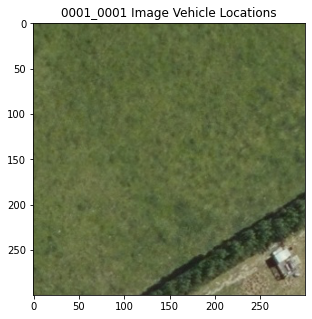

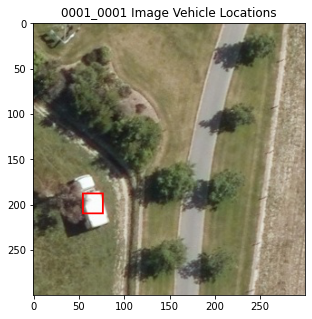

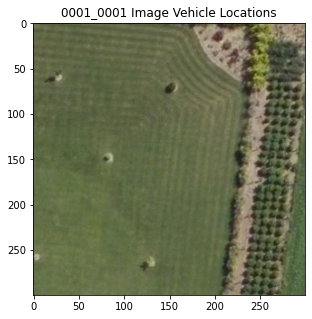

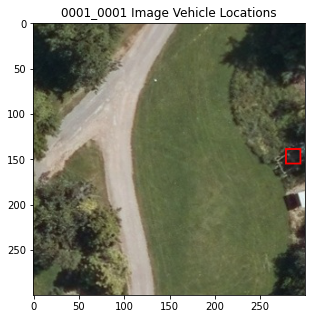

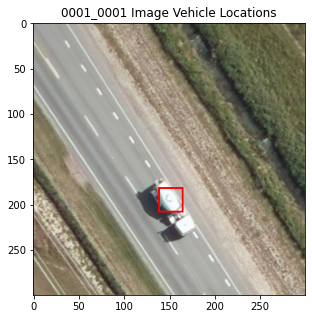

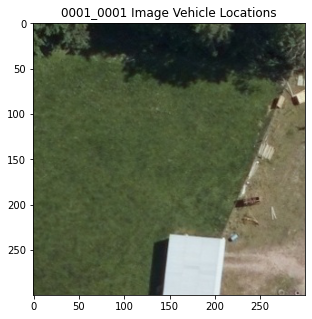

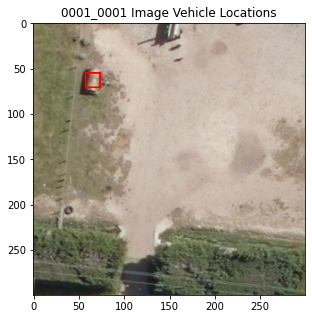

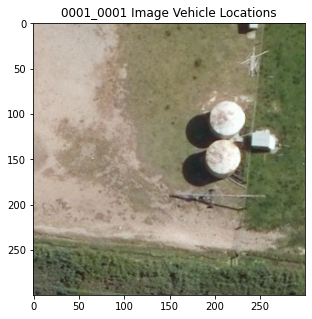

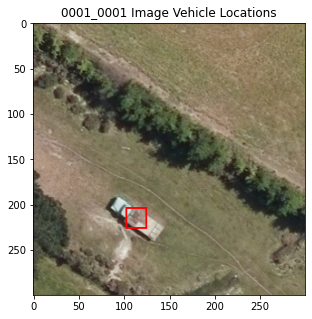

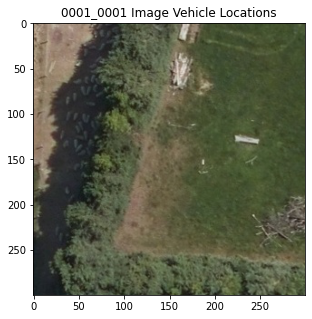

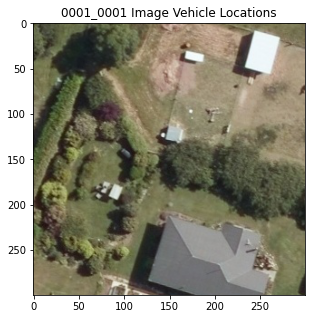

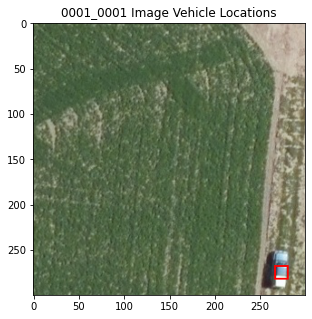

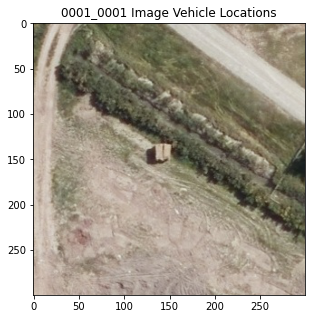

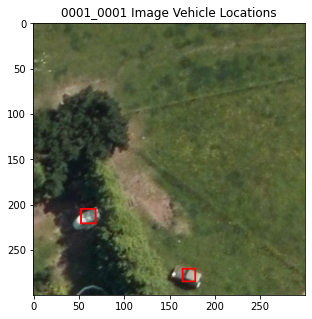

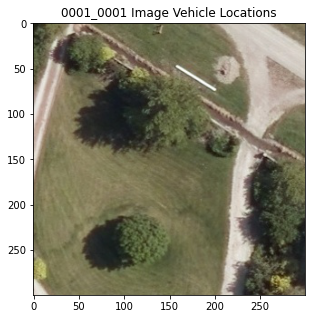

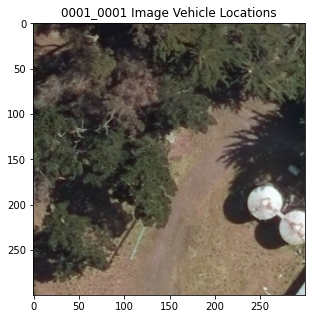

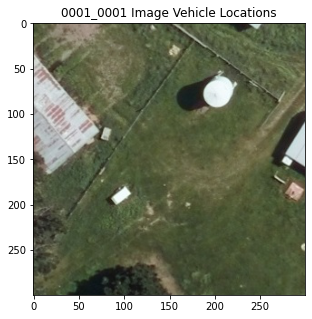

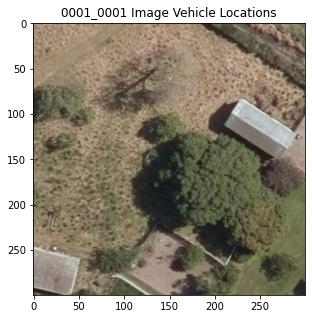

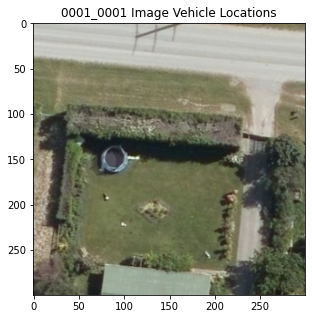

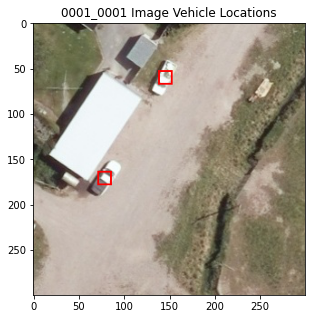

In [27]:
#workers
w,h = 300,300 #inputImageProperties
for url in urls:
    
    image_url,slice_loc,worker1,worker2,worker3,worker4,worker5,truck,small,specialized,trailer_small,num_vehicles = df.loc[df['image_url'] == url].values.tolist()[0]
    imname = os.path.basename(image_url)
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))
    
    draw = ImageDraw.Draw(img)
    cols = itertools.cycle([(255,0,0,0),(255,255,0,0),(202, 44, 146,0)])
    l = [truck,small,specialized,trailer_small]
    
    #slice locations from main image, in case to load main image crop from original
    y,x = slice_loc
    for locations,class_name in zip(l,['truck','small','specialized','trailer_small']): #,'trailer_small']):
        locs = []
        if len(locations) > 1:
            
            for x1,y1 in zip(locations[0], locations[1]):
                locs.append([x1-x,y1-y])
                
        elif len(locations) == 1:
            
            x2,y2 = locations[0]
            locs.append( [x2-x,y2-y])
            
        else:
            locs = []
        xy = np.array(locs, dtype='int')
        radius = radii[class_name]
        
        for row, col in locs:
            #mask = np.sqrt((rows - row)**2 + (cols - col)**2) <= radius
            #local_sum.append(np.sum(mask*img))
            #print((row-radius, col-radius, row+radius, col+radius),img.size,radius)
            size = radii[class_name]
            #print(( col-size,row-size,  col+size,row+size,))
            draw.rectangle(( col-size,row-size,  col+size,row+size,),outline=(255,0,0,0), width=2)

        #ax.imshow(img,cmap=cmap)
        #for i, [row, col] in enumerate(xy):
            #ax.add_patch(Circle((col, row), radius=75, color='red'))
            #ax.add_patch(Rectangle((col+size, row+size),class_sizes[class_name],class_sizes[class_name], color='red',fill=None))
            #plt.text(col, row, '{:.2f}'.format(local_sum[i]), ha='center', va='center')
    img.convert('RGB').save(os.path.join(images_path,imname))
    w,h = img.size
    plt.figure(figsize=(5, 5))
    plt.imshow(np.asarray(img))
    plt.title("0001_0001 Image Vehicle Locations")

In [28]:
def url_to_pilimage(url):
    # download the image, convert it to a NumPy array, and then read
    # it into OpenCV format
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # return the image
    return img

### The following NMS method is Soft NMS with Greedy approach using Tensorflow library.
### The function expects image url with multiple bounding boxes submitted by workers, ground truth, center locations, selected ids based on scores from exponential L2 Norm.

In [36]:
def soft_nms(img_url, bboxes, scores,numvehicles, groundtruth, centers, ids):
    import matplotlib.pyplot as plt
    import tensorflow as tf
    imname = os.path.basename(img_url)
    
    selected_indices, selected_scores = tf.image.non_max_suppression_with_scores(
        bboxes, scores, numvehicles, iou_threshold=0.5,
        score_threshold=float('-inf'), soft_nms_sigma=0.5)
    
    image = url_to_pilimage(img_url)
    orig = image.copy()
    
    draw = ImageDraw.Draw(orig)
    # loop over the bounding boxes for each image and draw them
    for (startX, startY, endX, endY) in bboxes:
        draw.rectangle((startX, startY, endX, endY),outline=(255,0,0,0), width=2)
    for (cx,cy) in groundtruth:
        draw.point((cy+1, cx-1, cy+1, cx+1),fill=(0,0,255,0))
    for (cx,cy) in centers:
        draw.point((cy-1, cx-1, cy+1, cx+1),fill=(0,0,255,0))
    orig.convert('RGB').save(os.path.join(images_path,"worker_annotations",imname))
    plt.figure(figsize=(5, 5))
    plt.imshow(np.asarray(orig))
    plt.title("Orig")
    
    draw = ImageDraw.Draw(image)

    # perform non-maximum suppression on the bounding boxes
    pick = bboxes[selected_indices.numpy()]
    #print("selected",pick,selected_indices.numpy())
    print("[x] after applying non-maximum, %d bounding boxes" % (len(pick)))
    # loop over the picked bounding boxes and draw them
    for (startX, startY, endX, endY) in pick:
        draw.rectangle((startX, startY, endX, endY),outline=(0,255,0,0), width=2)
    # display the images
    
    image.convert('RGB').save(os.path.join(images_path,"bb_nms_annotations","new1",imname))
    plt.figure(figsize=(5, 5))
    plt.imshow(np.asarray(image))
    plt.title("After NMS")

### Plot the annotations for all bounding boxes received

In [37]:
def plot_this_annotations(img_url, bboxes,numvehicles, groundtruth, centers, worker):
    import matplotlib.pyplot as plt
    imname = os.path.basename(img_url)
    
    image = url_to_pilimage(img_url)
    orig = image.copy()
    
    draw = ImageDraw.Draw(orig)
    # loop over the bounding boxes for each image and draw them
    for (startX, startY, endX, endY) in bboxes:
        draw.rectangle((startX, startY, endX, endY),outline=(255,0,0,0), width=2)
    for (cx,cy) in groundtruth:
        draw.ellipse((cy-1, cx-1, cy+1, cx+1),fill=(0,0,255,0))
    for (cx,cy) in centers:
        draw.ellipse((cy-1, cx-1, cy+1, cx+1),fill=(255,0,0,0))
    orig.convert('RGB').save(os.path.join(images_path,"worker_annotations","invalid",worker+"_"+imname))
    plt.figure(figsize=(5, 5))
    plt.imshow(np.asarray(orig))
    plt.title("Worker "+ worker + " Annotations")

### The following scoring method takes L2 norm between received bounding boxes and ground truth and based on nearest distacnes that match the tolerance radii,
### generates L2 Norm (Euclidean distances) to Gaussian kernel which serves as similarity score. (Suggested by Stan)

In [38]:
def get_scores(centers,groundtruth, class_name, numvehicles, radius):
    # if there are no boxes, return an empty list
    if len(centers) == 0:
        return []
    #initialize distances, ids
    distances = [None]*len(centers)
    ids = []
    scores= []
    #get L2 norm
    for i,center in enumerate(centers):
        dist = np.linalg.norm( groundtruth-center, axis=1)
        ind = np.where(dist <= radius)
        #print("dist",i,ind,ind[0],groundtruth, center,dist,not np.size(ind) )
        
        if not np.size(ind):
            distances[i] = -1
            #scores.append(0)
        elif len(ind[0]) > 1:
            #for j in ind:
                #print(np.exp(-1*dist[j]**2))
            ids.append(i)
            distances[i] = dist[j][0]
            #scores.append(1)
        else:
            ids.append(i)
            distances[i] = dist[ind][0]
            scores.append(1)
    #print("distances",ids, distances, centers[ids])
    scores = []
    for i,d in enumerate(distances):
        scores.append(1-np.exp(-1*d**2)) #s = 1 constant, s^2 = 1 -> denominator to kernel function
    for id in ids:
        if distances[id] == -1:
            scores[id] = 0
    print("scores", scores, distances)
    return [scores, distances, ids]

In [39]:
# w,h = 300,300 #inputImageProperties

# for url in urls:
    
#     image_url,slice_loc,worker1,worker2,worker3,worker4,worker5,truck,small,specialized,trailer_small,num_vehicles = df.loc[df['image_url'] == url].values.tolist()[0]
#     imname = os.path.basename(image_url)

#     #cols = itertools.cycle([(255,0,0,0),(255,255,0,0),(202, 44, 146,0)])
#     l = [truck,small,specialized,trailer_small]
#     y,x = slice_loc
#     for locations,class_name in zip( l,['truck','small','specialized','trailer_small']): #,'trailer_small']):
#         locs = []
#         if len(locations) > 1:
#             for x1,y1 in zip(locations[0], locations[1]):
#                 locs.append([x1-x,y1-y])
#         elif len(locations) == 1:
#             x2,y2 = locations[0]
#             locs.append( [x2-x,y2-y])
#         else:
#             locs = []
#         xy = np.array(locs, dtype='int')
#         radius = radii[class_name]
#         gt = []
#         c = []
#         bb = []
#         for row, col in locs:
#             size = radii[class_name]
#             print("locs",row, col)
#             gt.append([row, col])
#             print(( col-size,row-size,  col+size,row+size,))
#         counter = 0
#         for worker in [worker1,worker2,worker3,worker4,worker5]:
#             counter += 1
#             if len(worker) > 0:
#                 bboxes = []
#                 c = []
#                 bb = []
                
#                 for loc in worker:
#                     row,col = loc
#                     #print("loc, row, col",loc[::-1], col, row)
#                     c.append(loc[::-1])
#                     bb.append([ row-size, col-size, row+size,col+size])
            
#                 if len(bb) > 0 and len(gt) == 0:
#                     print("bb,c,gt",bb,c,gt)
#                     centers = np.array(c)
#                     groundtruth = np.array(gt)
#                     bboxes = np.array(bb)
#                     plot_this_annotations(url, bboxes,numvehicles, groundtruth, centers, "worker_"+str(counter))    

        
#             #scores, distances, ids = get_scores(centers,groundtruth, class_name, numvehicles, radii[class_name])
#             #print(url,scores, distances)
#             #bb.append(( col-size,row-size,  col+size,row+size))

scores [1.0, 1.0, 0.9999999999861121, 0.6321205588285577, 0.8646647167633874] [7.810249675906654, 6.708203932499369, 5.0, 1.0, 1.4142135623730951]
https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-12960-4800.png [1.0, 1.0, 0.9999999999861121, 0.6321205588285577, 0.8646647167633874] [7.810249675906654, 6.708203932499369, 5.0, 1.0, 1.4142135623730951]
[x] after applying non-maximum, 1 bounding boxes
scores [0.9999999847700203, 0.9816843611112658, 0.9932620530009145, 0.9999999979388464, 0.9996645373720975] [4.242640687119285, 2.0, 2.23606797749979, 4.47213595499958, 2.8284271247461903]
https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-7440-3600.png [0.9999999847700203, 0.9816843611112658, 0.9932620530009145, 0.9999999979388464, 0.9996645373720975] [4.242640687119285, 2.0, 2.23606797749979, 4.47213595499958, 2.8284271247461903]
[x] after applying non-maximum, 1 bounding boxes
scores [0.6321205588285577] [-1]
https://mturk-s3-cg.

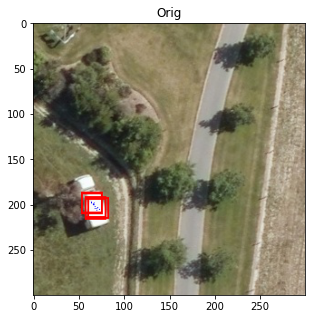

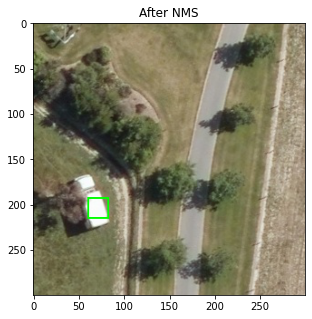

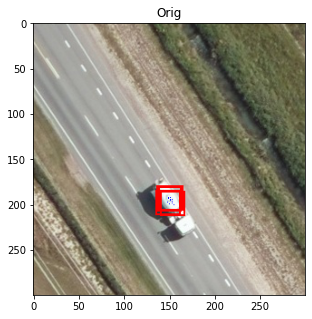

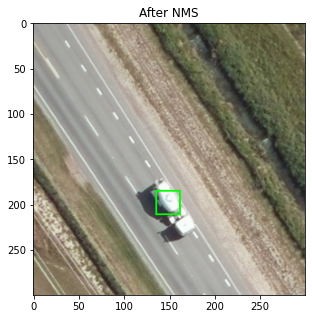

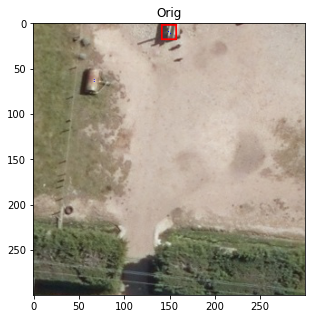

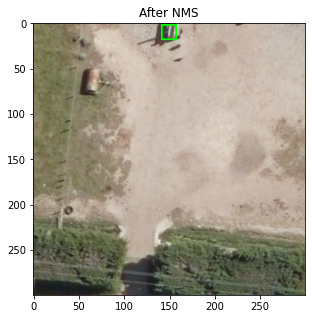

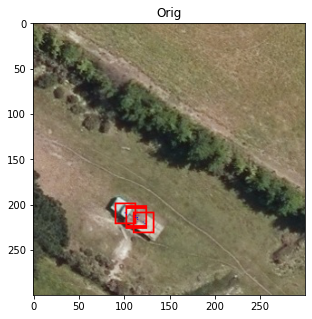

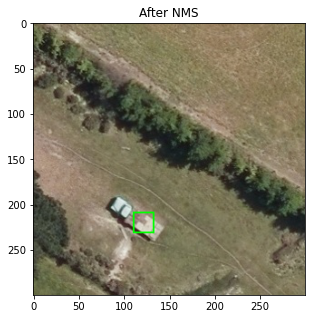

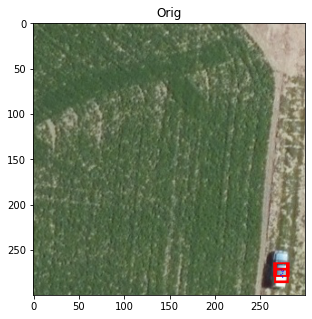

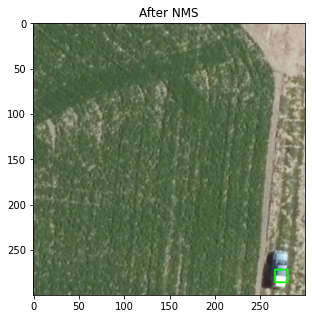

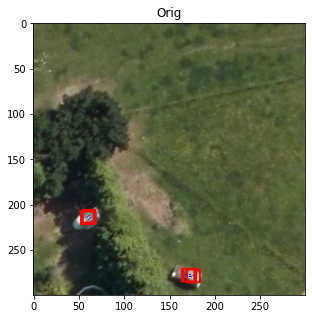

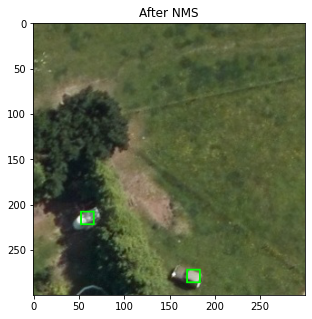

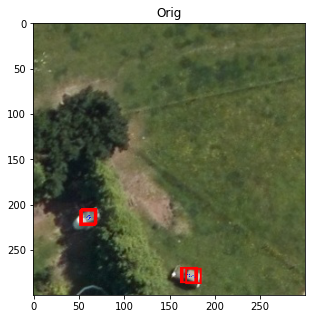

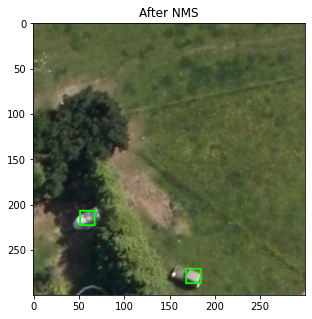

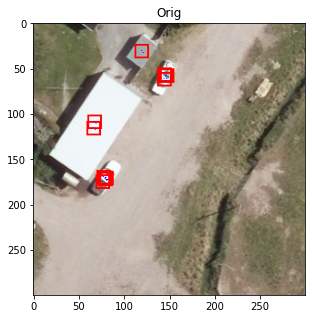

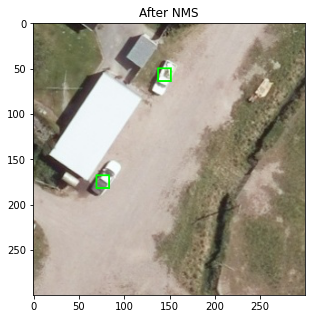

In [40]:
w,h = 300,300 #inputImageProperties

# fotr each image url
for url in urls:
    
    # get all entries for this row from dataframe
    image_url,slice_loc,worker1,worker2,worker3,worker4,worker5,truck,small,specialized,trailer_small,num_vehicles = df.loc[df['image_url'] == url].values.tolist()[0]
    imname = os.path.basename(image_url)

    #cols = itertools.cycle([(255,0,0,0),(255,255,0,0),(202, 44, 146,0)])
    l = [truck,small,specialized,trailer_small]
    y,x = slice_loc
    
    # for each class specific location
    # we need the class label to get the specific tolerance level for a marked location submitted by worker
    for locations,class_name in zip( l,['truck','small','specialized','trailer_small']): #,'trailer_small']):
        locs = []
        if len(locations) > 1:
            for x1,y1 in zip(locations[0], locations[1]):
                locs.append([x1-x,y1-y])
        elif len(locations) == 1:
            x2,y2 = locations[0]
            locs.append( [x2-x,y2-y])
        else:
            locs = []
        xy = np.array(locs, dtype='int')
        radius = radii[class_name]
        gt = []
        c = []
        bb = []
        for row, col in locs:
            size = radii[class_name]
            #print("locs",row, col)
            gt.append([row, col])
            #print(( col-size,row-size,  col+size,row+size,))

        for worker in [worker1,worker2,worker3,worker4,worker5]:
            if len(worker) > 0:
                for loc in worker:
                    row,col = loc
                    #print("loc, row, col",loc[::-1], col, row)
                    c.append(loc[::-1])
                    bb.append([ row-size, col-size, row+size,col+size])
            
        if len(bb) > 0 and len(gt) > 0 and numvehicles > 0:
            #print("bb,c,gt",bb,c,gt)
            centers = np.array(c)
            groundtruth = np.array(gt)
            bboxes = np.array(bb)
        
            scores, distances, ids = get_scores(centers,groundtruth, class_name, numvehicles, radii[class_name])
            print(url,scores, distances)
            soft_nms(url,bboxes, scores,num_vehicles, groundtruth, centers, ids)    
            #bb.append(( col-size,row-size,  col+size,row+size))

### This is Fast Non Max Suppression algorithm. 
### Fast since we skip two for loops by using Numpy.maximum since complexity is ~ O(n).  In case of two for loops  time complexity is ~ O(n)*O(n) 

In [41]:
# import the necessary packages
import numpy as np
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes	
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

In [42]:
def fast_nms(img_url, bboxes, numvehicles, groundtruth, centers, ids):
    import matplotlib.pyplot as plt
    imname = os.path.basename(img_url)
    
    image = url_to_pilimage(img_url)
    orig = image.copy()
    
    draw = ImageDraw.Draw(orig)
    # loop over the bounding boxes for each image and draw them
    for (startX, startY, endX, endY) in bboxes:
        draw.rectangle((startX, startY, endX, endY),outline=(255,0,0,0), width=2)
    for (cx,cy) in groundtruth:
        draw.point((cy+1, cx-1, cy+1, cx+1),fill=(0,0,255,0))
    for (cx,cy) in centers:
        draw.point((cy-1, cx-1, cy+1, cx+1),fill=(0,0,255,0))
    orig.convert('RGB').save(os.path.join(images_path,"worker_annotations",imname))
    plt.figure(figsize=(5, 5))
    plt.imshow(np.asarray(orig))
    plt.title("Orig")
    
    draw = ImageDraw.Draw(image)
    pick = non_max_suppression_fast(bboxes, 0.3)
    
    # perform non-maximum suppression on the bounding boxes
    #pick = bboxes[selected_indices.numpy()]
    #print("selected",pick)
    print("[x] after applying non-maximum, %d bounding boxes" % (len(pick)))
    # loop over the picked bounding boxes and draw them
    for (startX, startY, endX, endY) in pick:
        draw.rectangle((startX, startY, endX, endY),outline=(0,255,0,0), width=2)
    # display the images
    
    image.convert('RGB')#.save(os.path.join(images_path,"bb_nms_annotations",imname))
    plt.figure(figsize=(5, 5))
    plt.imshow(np.asarray(image))
    plt.title("After NMS")

scores [1.0, 1.0, 0.9999999999861121, 0.6321205588285577, 0.8646647167633874] [7.810249675906654, 6.708203932499369, 5.0, 1.0, 1.4142135623730951]
https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-12960-4800.png [1.0, 1.0, 0.9999999999861121, 0.6321205588285577, 0.8646647167633874] [7.810249675906654, 6.708203932499369, 5.0, 1.0, 1.4142135623730951]
[x] after applying non-maximum, 1 bounding boxes
scores [0.9999999847700203, 0.9816843611112658, 0.9932620530009145, 0.9999999979388464, 0.9996645373720975] [4.242640687119285, 2.0, 2.23606797749979, 4.47213595499958, 2.8284271247461903]
https://mturk-s3-cg.s3.amazonaws.com/task2/selwyn/smallbatch/0001_0001/0001-0001-7440-3600.png [0.9999999847700203, 0.9816843611112658, 0.9932620530009145, 0.9999999979388464, 0.9996645373720975] [4.242640687119285, 2.0, 2.23606797749979, 4.47213595499958, 2.8284271247461903]
[x] after applying non-maximum, 1 bounding boxes
scores [0.6321205588285577] [-1]
https://mturk-s3-cg.

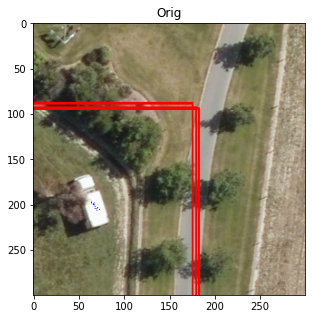

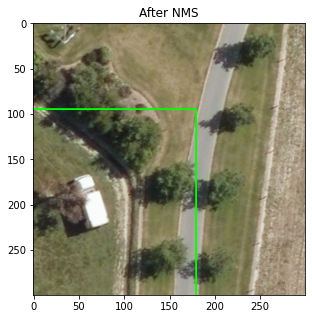

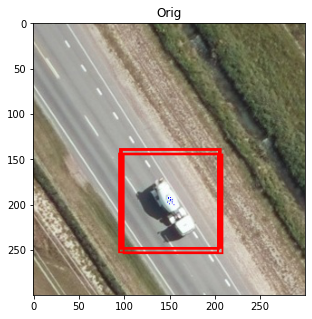

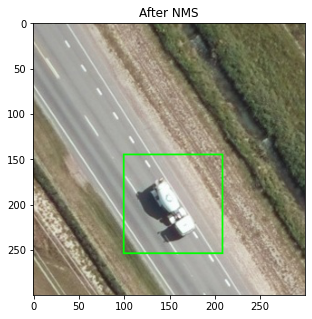

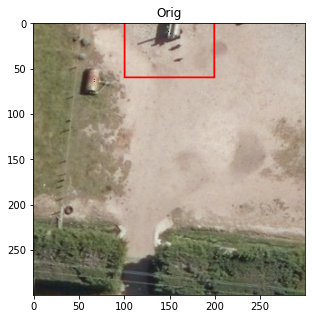

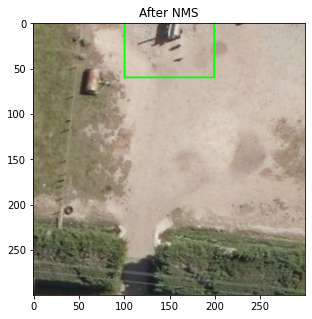

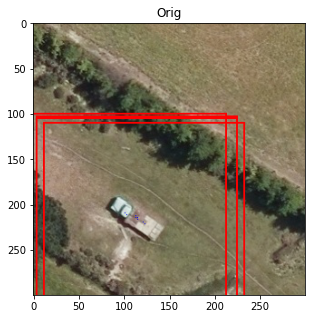

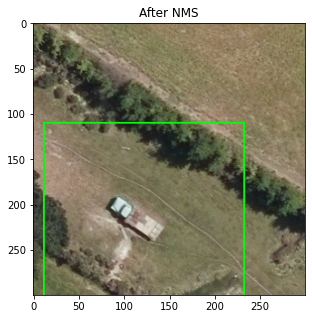

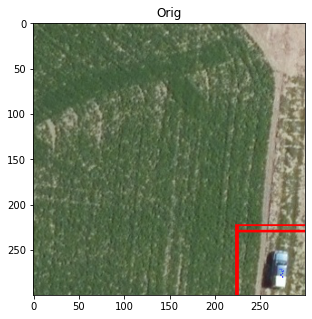

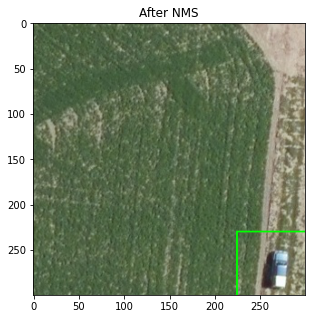

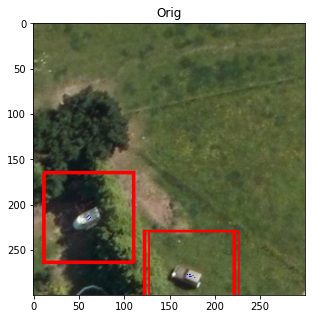

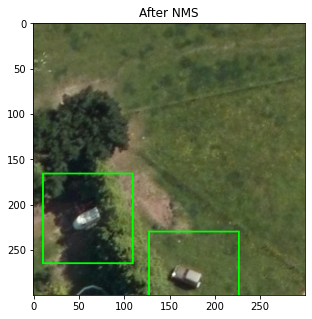

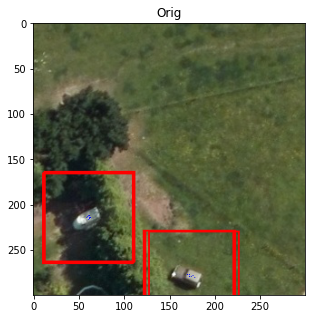

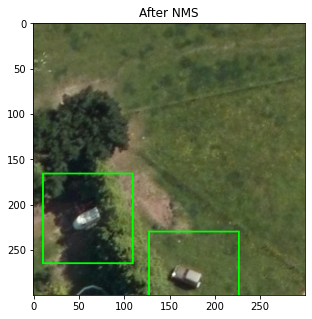

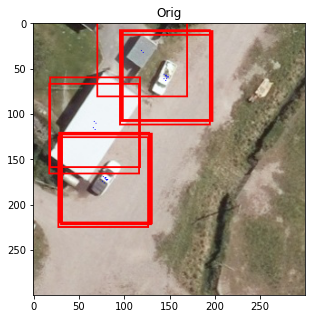

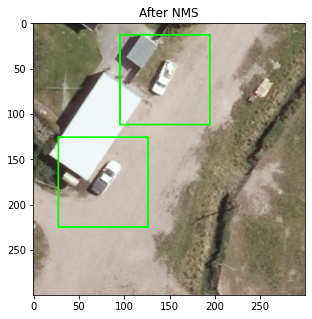

In [43]:
w,h = 300,300 #inputImageProperties

for url in urls:
    
    image_url,slice_loc,worker1,worker2,worker3,worker4,worker5,truck,small,specialized,trailer_small,num_vehicles = df.loc[df['image_url'] == url].values.tolist()[0]
    imname = os.path.basename(image_url)

    #cols = itertools.cycle([(255,0,0,0),(255,255,0,0),(202, 44, 146,0)])
    l = [truck,small,specialized,trailer_small]
    y,x = slice_loc
    for locations,class_name in zip( l,['truck','small','specialized','trailer_small']): #,'trailer_small']):
        locs = []
        if len(locations) > 1:
            for x1,y1 in zip(locations[0], locations[1]):
                locs.append([x1-x,y1-y])
        elif len(locations) == 1:
            x2,y2 = locations[0]
            locs.append( [x2-x,y2-y])
        else:
            locs = []
        xy = np.array(locs, dtype='int')
        radius = radii[class_name]
        gt = []
        c = []
        bb = []
        for row, col in locs:
            size = class_sizes[class_name]//2
            #print("locs",row, col)
            gt.append([row, col])
            #print(( col-size,row-size,  col+size,row+size,))

        for worker in [worker1,worker2,worker3,worker4,worker5]:
            if len(worker) > 0:
                for loc in worker:
                    row,col = loc
                    #print("loc, row, col",loc[::-1], col, row)
                    c.append(loc[::-1])
                    bb.append([ row-size, col-size, row+size,col+size])
            
        if len(bb) > 0 and len(gt) > 0 and numvehicles > 0:
            #print("bb,c,gt",bb,c,gt)
            centers = np.array(c)
            groundtruth = np.array(gt)
            bboxes = np.array(bb)
        
            scores, distances, ids = get_scores(centers,groundtruth, class_name, numvehicles, radii[class_name])
            print(url,scores, distances)
            fast_nms(url,bboxes, num_vehicles, groundtruth, centers, ids)    
            #bb.append(( col-size,row-size,  col+size,row+size))

In [50]:
def get_scores_distances(centers,groundtruth, class_name, numvehicles, radius):
    # if there are no boxes, return an empty list
    if len(centers) == 0:
        return []
    #print("num annot", centers.shape, centers, groundtruth)
    #initialize distances, ids
    distances = [None]*len(centers)
    ids = []
    fp_locs = []
    tp_locs = []
    invalid = []
    scores= []
    rest = []
    sigma = 2 * radius/3
    beta = 1/(2*sigma*sigma)
    sigmasqrtpi = 1/(np.sqrt(2*np.pi)*sigma)
    #get L2 norm
    for i,center in enumerate(centers):
        dist = np.linalg.norm( groundtruth-center, axis=1)
        ind = np.where(dist <= radius)
        #print("dist",i,ind,ind[0],groundtruth, center,dist,not np.size(ind) )
        if not np.size(ind):
            rest.append(i)
            invalid.append(center.tolist())
        elif len(ind[0]) > 1:
            ids.append(i)
            distances[i] = dist[ind][0]
        else:
            ids.append(i)
            distances[i] = dist[ind][0]
    #print("distances",ids, distances, centers[ids])
    scores = []
    if len(ids) > 0:
        for d in distances:
            if d:
                scores.append( sigmasqrtpi * np.exp(-1*d*d*beta )) #sigma = 
        for id in ids:
            if distances[id] == -1:
                scores[id] = 0
        #print("scores", scores, distances,ids)
        selected = np.array(scores)
        tpids = np.where(selected <= 1)
       # print("tpids",np.size(tpids) )
        for id in tpids:
            #print("id",id)
            tp_locs.append(centers[id].tolist())
        fpids = np.where(selected > 1)
        #print("fpids",np.size(fpids) )
        for id in fpids:
            #print("id",id)
            fp_locs.append(centers[id].tolist())
        return [scores, distances ,fp_locs,tp_locs,invalid,np.size(tpids),np.size(fpids), ids, rest]
    else:
        return [[], distances ,[],[],invalid,0,0, ids, rest]

In [51]:
w,h = 300,300 #inputImageProperties
worker_scores = []
for url in urls:
    
    image_url,slice_loc,worker1,worker2,worker3,worker4,worker5,truck,small,specialized,trailer_small,num_vehicles = df.loc[df['image_url'] == url].values.tolist()[0]
    imname = os.path.basename(image_url)

    #cols = itertools.cycle([(255,0,0,0),(255,255,0,0),(202, 44, 146,0)])
    l = [truck,small,specialized,trailer_small]
    y,x = slice_loc
    for locations,class_name in zip( l,['truck','small','specialized','trailer_small']): #,'trailer_small']):
        locs = []
        if len(locations) > 1:
            for x1,y1 in zip(locations[0], locations[1]):
                locs.append([x1-x,y1-y])
        elif len(locations) == 1:
            x2,y2 = locations[0]
            locs.append( [x2-x,y2-y])
        else:
            locs = []
        xy = np.array(locs, dtype='int')
        radius = radii[class_name]
        gt = []
        for row, col in locs:
            size = radii[class_name]
            #print("locs",row, col)
            gt.append([row, col])
            #print(( col-size,row-size,  col+size,row+size,))

        for i,worker in enumerate([worker1,worker2,worker3,worker4,worker5]):
            c = []
            bb = []
            #print(i,worker)
            if len(worker) > 0:
                for loc in worker:
                    row,col = loc
                    #print("worker",str(i),"loc, row, col",loc[::-1], col, row)
                    c.append(loc[::-1])
                    bb.append([ row-size, col-size, row+size,col+size])
            
                if len(bb) > 0 and len(gt) > 0 and numvehicles > 0:
                    #print("bb,c,gt",bb,c,gt)
                    centers = np.array(c)
                    groundtruth = np.array(gt)
                    bboxes = np.array(bb)

                    scores, distances ,fp_locs,tp_locs,invalid,tp,fp, ids, rest = get_scores_distances(centers,groundtruth, class_name, numvehicles, radii[class_name])
                    #print("worker"+str(i),url,centers,groundtruth,scores, distances ,fp_locs,tp_locs,invalid, ids, rest)
                    worker_scores.append({"worker":str(i), "url":url, "vehicle_class":class_name,"num_vehicles":num_vehicles, "groundtruth":gt, "annotations":c,
                                          "num_annotations":len(c),"fp_locs":fp_locs,"tp_locs":tp_locs,"invalid":[], "tp":tp,"fp":fp, "scores":scores,"distances":distances})

                elif numvehicles == 0:
                    #print("bb,c,gt",bb,c,gt)
                    centers = np.array(c)
                    groundtruth = np.array(gt)
                    bboxes = np.array(bb)
                    print("zero vehicles")
                    worker_scores.append({"worker":str(i), "url":url, "vehicle_class":class_name,"num_vehicles":0, "groundtruth":gt, "annotations":c,
                                          "num_annotations":len(c),"fp_locs":c,"tp_locs":[], "invalid":[],"tp":0,"fp":len(c),"scores":[],"distances":[]})

In [56]:
worker_scores[0]['worker'],worker_scores[0]['num_vehicles'],worker_scores[0]['annotations'],worker_scores[0]['scores'],worker_scores[0]['distances'],worker_scores[0]['tp'],worker_scores[0]['fp']

('0', 1, [[204, 72]], [0.030916616096185196], [7.810249675906654], 1, 0)

In [53]:
result = pd.DataFrame.from_dict(worker_scores)
result.to_csv(os.path.join(images_path,"worker_scores.csv"), index=False)

In [55]:
result.head()

worker                                                url vehicle_class  \
0      0  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...         truck   
1      1  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...         truck   
2      2  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...         truck   
3      3  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...         truck   
4      4  https://mturk-s3-cg.s3.amazonaws.com/task2/sel...         truck   

   num_vehicles  groundtruth  annotations  num_annotations fp_locs  \
0             1  [[199, 66]]  [[204, 72]]                1    [[]]   
1             1  [[199, 66]]  [[205, 69]]                1    [[]]   
2             1  [[199, 66]]  [[203, 69]]                1    [[]]   
3             1  [[199, 66]]  [[199, 65]]                1    [[]]   
4             1  [[199, 66]]  [[198, 65]]                1    [[]]   

         tp_locs invalid  tp  fp                  scores             distances  
0  [[[204, 72]]]      []   1   0  [0.030916616096185196]   [7.810249675906654]  
1  [[[205, 69]]]      []   1   0   [0.03568707844953987]   [6.708203932499369]  
2  [[[203, 69]]]      []   1   0   [0.04269822274721806]                 [5.0]  
3  [[[199, 65]]]      []   1   0   [0.05295273082977633]                 [1.0]  
4  [[[198, 65]]]      []   1   0   [0.05247995112560072]  [1.4142135623730951]